In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, make_scorer,mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPClassifier

# I. Data Preprocessing

In [2]:
path = kagglehub.dataset_download("lainguyn123/student-performance-factors")
print("Path to dataset files:", path)

csv_file_path = os.path.join(path, "StudentPerformanceFactors.csv")

df = pd.read_csv(csv_file_path)

df.shape


Path to dataset files: C:\Users\bhara\.cache\kagglehub\datasets\lainguyn123\student-performance-factors\versions\8


(6607, 20)

In [3]:
df.describe()

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [4]:
# check the type of features
# sort categorical and numerical data
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)
df.info()

Numerical Columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']
Categorical Columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previou

In [5]:
# handle missing data
df.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

In [6]:
# drop null value
df = df.dropna()
print(df.shape)
df.isnull().sum()

(6378, 20)


Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64

In [7]:
dfColumns = ['Parental_Involvement',
          'School_Type',
          'Access_to_Resources',
          'Extracurricular_Activities',
          'Motivation_Level',
          'Internet_Access',
          'Family_Income',
          'Teacher_Quality',
          'Peer_Influence',
          'Learning_Disabilities',
          'Parental_Education_Level',
          'Distance_from_Home',
          'Gender'
         ]
df = pd.get_dummies(df, columns=dfColumns)

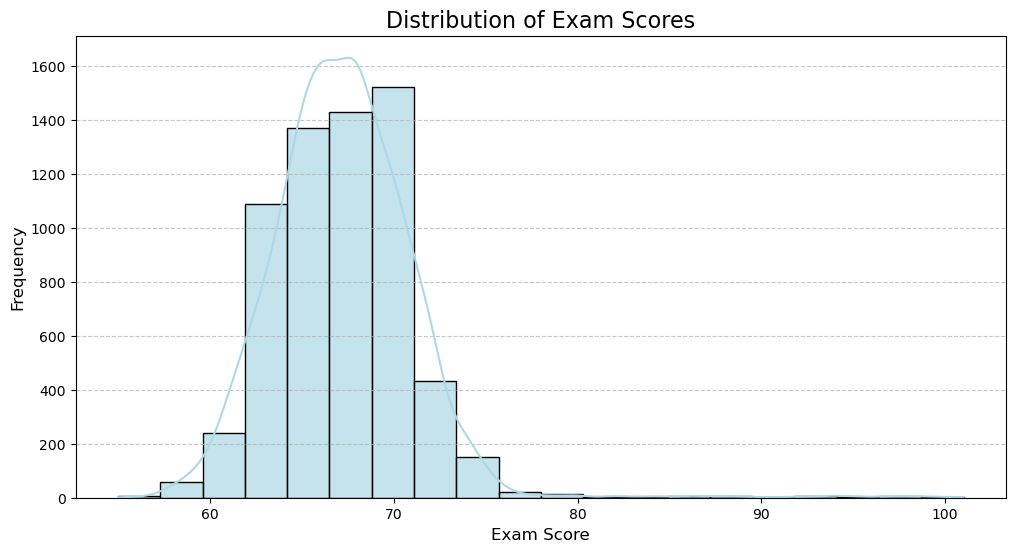

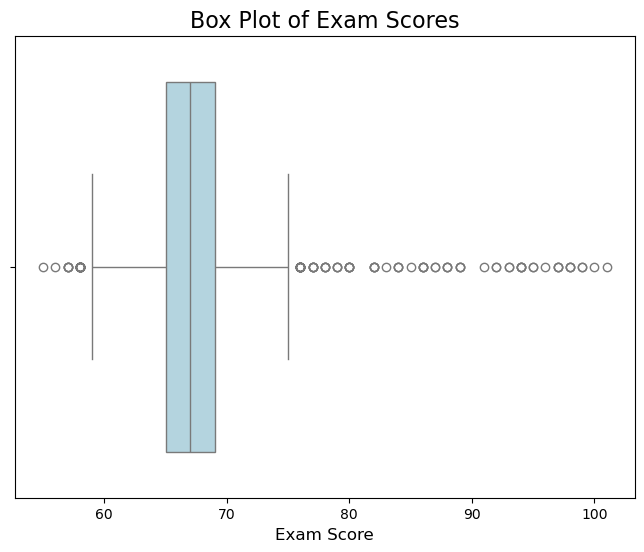

In [8]:
# Plot the distribution of 'Exam_Score'
plt.figure(figsize=(12, 6))
sns.histplot(df['Exam_Score'], bins=20, kde=True, color='lightblue', alpha=0.7)
plt.title('Distribution of Exam Scores', fontsize=16)
plt.xlabel('Exam Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot the box plot for 'Exam_Score'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Exam_Score'], color='lightblue')
plt.title('Box Plot of Exam Scores', fontsize=16)
plt.xlabel('Exam Score', fontsize=12)
plt.show()

# II. Binary Classification by KNN

In [9]:
# Task 1: Transforming the dataset to make it useful for binary classification by introducing the pass/fail value of let's say 60% - kNN Algorith
# Transform the dataset
threshold = 60  # Pass threshold
df.loc[df['Exam_Score'] >= threshold,'PassFail'] = 1
df.loc[df['Exam_Score'] < threshold,'PassFail'] = 0
df['PassFail'] = df['PassFail'].astype(int)
df

,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score,Parental_Involvement_High,Parental_Involvement_Low,Parental_Involvement_Medium,...,Learning_Disabilities_Yes,Parental_Education_Level_College,Parental_Education_Level_High School,Parental_Education_Level_Postgraduate,Distance_from_Home_Far,Distance_from_Home_Moderate,Distance_from_Home_Near,Gender_Female,Gender_Male,PassFail
0,23,84,7,73,0,3,67,False,True,False,...,False,False,True,False,False,False,True,False,True,1
1,19,64,8,59,2,4,61,False,True,False,...,False,True,False,False,False,True,False,True,False,1
2,24,98,7,91,2,4,74,False,False,True,...,False,False,False,True,False,False,True,False,True,1
3,29,89,8,98,1,4,71,False,True,False,...,False,False,True,False,False,True,False,False,True,1
4,19,92,6,65,3,4,70,False,False,True,...,False,True,False,False,False,False,True,True,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,25,69,7,76,1,2,68,True,False,False,...,False,False,True,False,False,False,True,True,False,1
6603,23,76,8,81,3,2,69,True,False,False,...,False,False,True,False,False,False,True,True,False,1
6604,20,90,6,65,3,2,68,False,False,True,...,False,False,False,True,False,False,True,True,False,1
6605,10,86,6,91,2,3,68,True,False,False,...,False,False,True,False,True,False,False,True,False,1


In [10]:
print(df.columns.tolist())

['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score', 'Parental_Involvement_High', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'School_Type_Private', 'School_Type_Public', 'Access_to_Resources_High', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_No', 'Extracurricular_Activities_Yes', 'Motivation_Level_High', 'Motivation_Level_Low', 'Motivation_Level_Medium', 'Internet_Access_No', 'Internet_Access_Yes', 'Family_Income_High', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_High', 'Teacher_Quality_Low', 'Teacher_Quality_Medium', 'Peer_Influence_Negative', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_No', 'Learning_Disabilities_Yes', 'Parental_Education_Level_College', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgraduate', 'Distance_from_Home_Far', 'Distance_from_Home_Moderate', 'Distance_from_Home_N

In [11]:
# Select Features and Target
features = ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Parental_Involvement_High', 'Parental_Involvement_Low', 'Parental_Involvement_Medium', 'School_Type_Private', 'School_Type_Public', 'Access_to_Resources_High', 'Access_to_Resources_Low', 'Access_to_Resources_Medium', 'Extracurricular_Activities_No', 'Extracurricular_Activities_Yes', 'Motivation_Level_High', 'Motivation_Level_Low', 'Motivation_Level_Medium', 'Internet_Access_No', 'Internet_Access_Yes', 'Family_Income_High', 'Family_Income_Low', 'Family_Income_Medium', 'Teacher_Quality_High', 'Teacher_Quality_Low', 'Teacher_Quality_Medium', 'Peer_Influence_Negative', 'Peer_Influence_Neutral', 'Peer_Influence_Positive', 'Learning_Disabilities_No', 'Learning_Disabilities_Yes', 'Parental_Education_Level_College', 'Parental_Education_Level_High School', 'Parental_Education_Level_Postgraduate', 'Distance_from_Home_Far', 'Distance_from_Home_Moderate', 'Distance_from_Home_Near', 'Gender_Female', 'Gender_Male']

X = df[features]
y = df['PassFail']

In [12]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (5102, 40)
X_test (1276, 40)
y_train (5102,)
y_test (1276,)


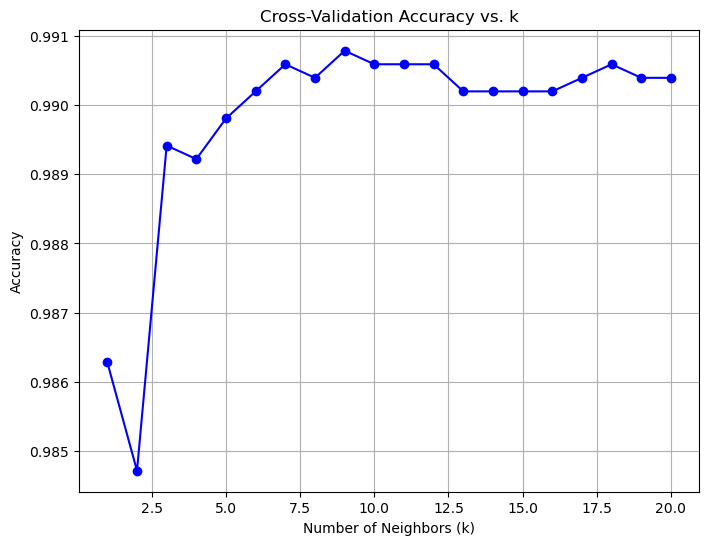

The optimal number of neighbors (k) is: 9
Test Accuracy using KNN, k=9: 98.98%


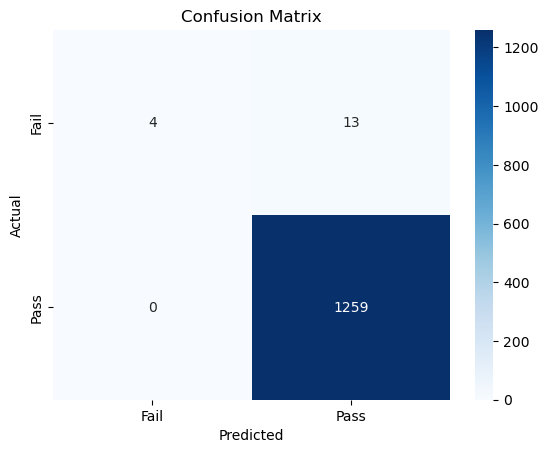

In [13]:
# Perform Cross-Validation
k_range = range(1, 21)
cv_scores = []

# Evaluate cross-validation score for each k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot cross-validation results
plt.figure(figsize=(8, 6))
plt.plot(k_range, cv_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation Accuracy vs. k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# Select the best k
best_k = k_range[cv_scores.index(max(cv_scores))]
print(f"The optimal number of neighbors (k) is: {best_k}")

# Train the KNN model with the best k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

# Evaluate the model on the test set
test_accuracy = knn_best.score(X_test, y_test)
print(f"Test Accuracy using KNN, k={best_k}: {test_accuracy * 100:.2f}%")

# Confusion Matrix
y_pred = knn_best.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Key Feature Importance

Top 10 Features Based on Importance:
                      Feature  Importance
0              Hours_Studied    0.195521
1                 Attendance    0.160160
3            Previous_Scores    0.076371
2                Sleep_Hours    0.044129
4          Tutoring_Sessions    0.038237
5          Physical_Activity    0.034671
35    Distance_from_Home_Far    0.026507
7   Parental_Involvement_Low    0.022246
17      Motivation_Level_Low    0.019459
25       Teacher_Quality_Low    0.018544


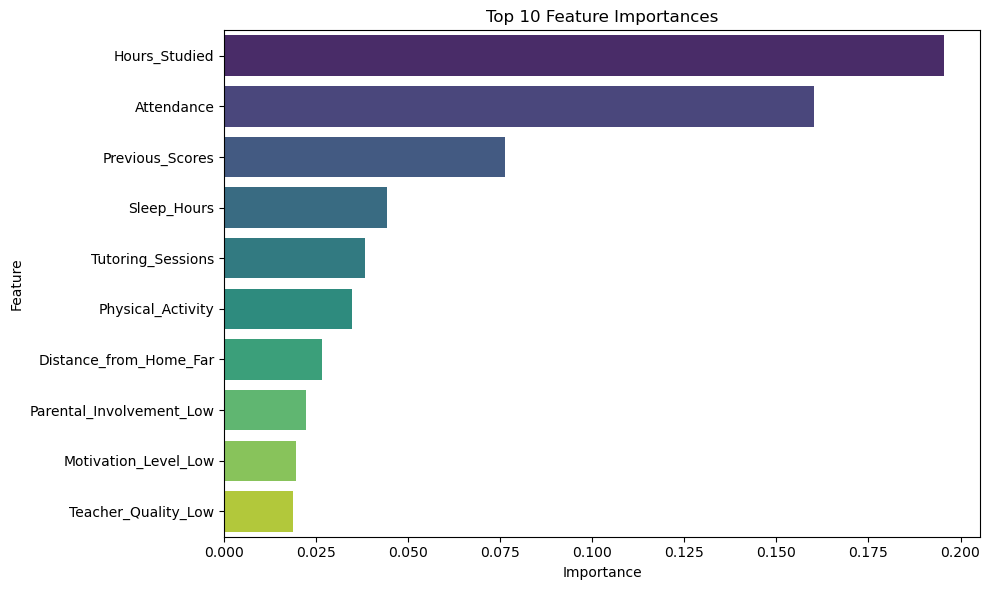

In [32]:
# Using Random Forest for Feature Importance
importances = []
rf = RandomForestClassifier(random_state=41)
rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
top_features = importance_df.head(10)
print("Top 10 Features Based on Importance:\n", top_features)
# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=top_features, palette='viridis', legend=False)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


Test Accuracy using KNN with Top 10 Features: 98.98%


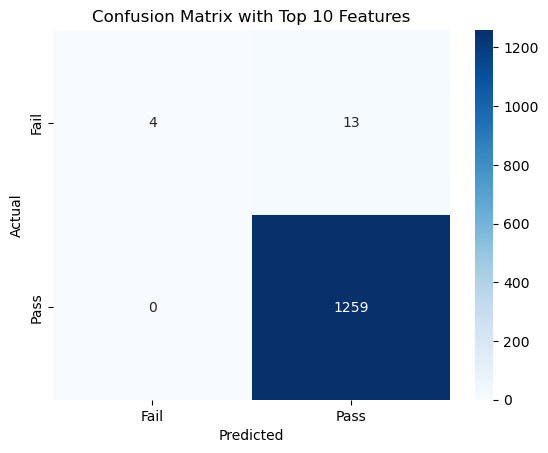

Classification Report with Top 10 Features:
               precision    recall  f1-score   support

           0       1.00      0.24      0.38        17
           1       0.99      1.00      0.99      1259

    accuracy                           0.99      1276
   macro avg       0.99      0.62      0.69      1276
weighted avg       0.99      0.99      0.99      1276



In [33]:
# Train KNN Model with Top Features
# Select the top 10 features for training
selected_features = ['Hours_Studied',
    'Attendance',  'Previous_Scores','Sleep_Hours',
    'Tutoring_Sessions', 'Physical_Activity','Distance_from_Home_Far',
     'Parental_Involvement_Low', 'Motivation_Level_Low','Teacher_Quality_Low'
]

# Subset the dataset
X_train_top = X_train[selected_features]
X_test_top = X_test[selected_features]

# Train KNN with the top 10 features
knn_top_features = KNeighborsClassifier(n_neighbors=best_k)
knn_top_features.fit(X_train_top, y_train)

# Evaluate the model
test_accuracy_top = knn_top_features.score(X_test_top, y_test)
print(f"Test Accuracy using KNN with Top 10 Features: {test_accuracy_top * 100:.2f}%")

# Confusion Matrix
y_pred_top = knn_top_features.predict(X_test_top)
conf_matrix_top = confusion_matrix(y_test, y_pred_top)

sns.heatmap(conf_matrix_top, annot=True, fmt='d', cmap='Blues', xticklabels=['Fail', 'Pass'], yticklabels=['Fail', 'Pass'])
plt.title('Confusion Matrix with Top 10 Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report with Top 10 Features:\n", classification_report(y_test, y_pred_top))


# III(a). Multiclassification By KNN

In [34]:
# Task2: Transforming the dataset to make it multiclassification by KNN
bins = [0, 60, 70, 80, 90, 105]
labels = ['F', 'D', 'C', 'B', 'A']

df['Grade'] = pd.cut(df['Exam_Score'], bins=bins, labels=labels, right=False)

# Label encoding (ensure it's from 1 to 5)
grade_mapping = {'F': 1, 'D': 2, 'C': 3, 'B': 4, 'A': 5}
df['GradeEncoded'] = df['Grade'].map(grade_mapping)


# Features and target variables
X = df.drop(['Grade', 'GradeEncoded'], axis=1)  # Features
y = df['GradeEncoded']  # Target variable (GradeEncoded)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)



The grade distribution is highly imbalanced, with the majority of the samples in GradeEncoded 2 (D) and 3 (C), while Grades 1 (F), 4 (B), and 5 (A) are significantly underrepresented. Imbalanced datasets can lead to biased models, where the classifier is skewed toward the majority classes.

To address this, we need to SMOTE (Synthetic Minority Oversampling Technique) generates synthetic samples for the minority classes.

In [35]:
# Apply SMOTE to balance the training data

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the balanced distribution
balanced_counts = pd.Series(y_train_balanced).value_counts()
print("Balanced Grade distribution:\n", balanced_counts)


Balanced Grade distribution:
 GradeEncoded
1    3784
2    3784
3    3784
4    3784
5    3784
Name: count, dtype: int64


Test Accuracy using multiclassification with k=5: 89.66%
Classification Report:
               precision    recall  f1-score   support

           1       0.42      0.85      0.56        13
           2       0.98      0.88      0.93       947
           3       0.74      0.95      0.84       307
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         4

    accuracy                           0.90      1276
   macro avg       0.80      0.94      0.85      1276
weighted avg       0.92      0.90      0.90      1276



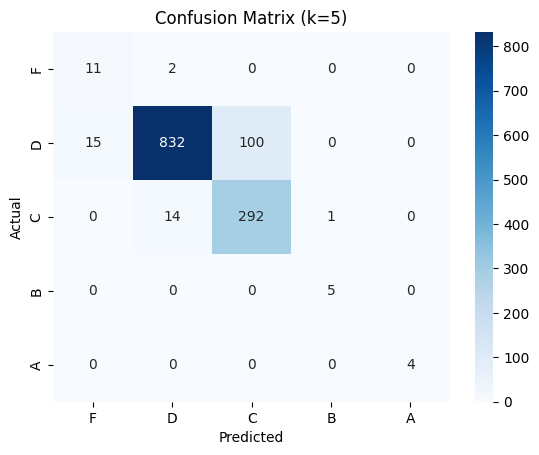

In [82]:

# Train the KNN model
best_k_balanced = 5
knn_balanced = KNeighborsClassifier(n_neighbors=best_k_balanced)
knn_balanced.fit(X_train_balanced, y_train_balanced)

# Evaluate the model on the test set
test_accuracy_balanced = knn_balanced.score(X_test, y_test)
print(f"Test Accuracy using multiclassification with k={best_k_balanced}: {test_accuracy_balanced * 100:.2f}%")

# Predictions and evaluation
y_pred_balanced = knn_balanced.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_balanced))

# Confusion Matrix
conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
sns.heatmap(conf_matrix_balanced, annot=True, fmt='d', cmap='Blues',
            xticklabels=['F', 'D', 'C', 'B', 'A'],
            yticklabels=['F', 'D', 'C', 'B', 'A'])
plt.title('Confusion Matrix (k=5)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# III(b). Multiclassification By Random Forests

Test Accuracy using Random Forest : 99.45%


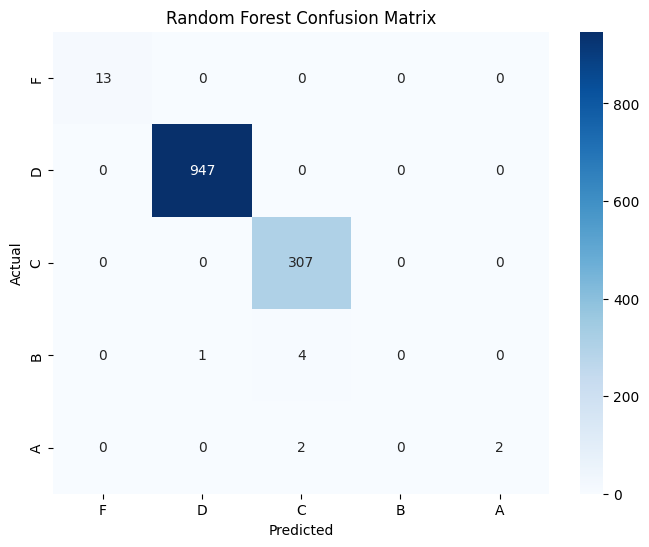

In [83]:
# Apply Random Forests
rf_model = RandomForestClassifier(class_weight='balanced',random_state=41)
rf_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred_rf = rf_model.predict(X_test)
test_accuracy_rf = rf_model.score(X_test, y_test)
print(f"Test Accuracy using Random Forest : {test_accuracy_rf * 100:.2f}%")

# Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# IV. Stochastic Gradient Descent Regression

Stochastic Gradient Descent (SGD) is an optimization algorithm used to minimize the loss function of models like Linear Regression and Classification models.

L2 Regularization helps prevent overfitting by penalizing large coefficients. This means the model won't "memorize" the training data and instead will generalize better to unseen data.

SGD Regression Performances:
Mean Squared Error (MSE): 0.08
R2 Score: 0.66


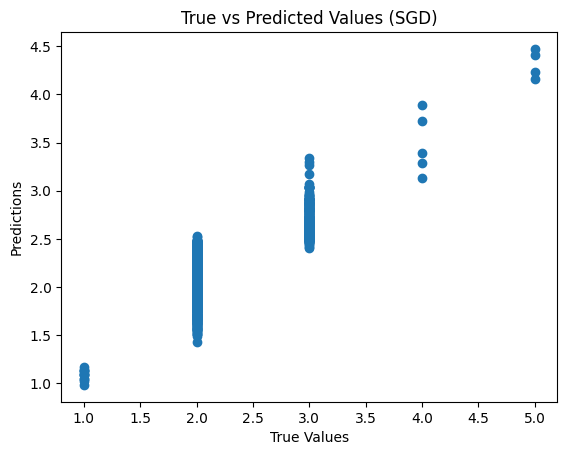

In [84]:
# Stochastic Gradient Descent Regression

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and Train SGD Regressor Model with Regularization (L2)
sgd_regressor = SGDRegressor(max_iter=1000, tol=1e-3, random_state=41, alpha=0.1)
sgd_regressor.fit(X_train_scaled, y_train)

# Predictions
y_pred = sgd_regressor.predict(X_test_scaled)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("SGD Regression Performances:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# Plotting True vs Predicted
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values (SGD)')
plt.show()


# V. Prediction by MLP Classifier

In [85]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.1],
    'max_iter': [1000],
    'early_stopping': [True, False]
}

# Initialize the MLPClassifier
mlp = MLPClassifier(random_state=42)

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters found: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'max_iter': 1000, 'solver': 'adam'}


In [86]:

# Apply the parameter to MPLClassifier
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    alpha=0.0001,
    early_stopping=False,
    max_iter=1000,
    solver='adam',
    random_state=42
)
mlp_classifier.fit(X_train, y_train)

y_pred_probs = mlp_classifier.predict_proba(X_test)
y_pred = mlp_classifier.predict(X_test)

# Initialize a counter for correct second-best predictions
correct_second_best = 0
total_samples = len(y_test)

# Loop through the test samples and check second-best predictions
for i in range(total_samples):
    top_2_preds = np.argsort(y_pred_probs[i])[::-1][:2]
    if top_2_preds[1] == y_test.iloc[i]:
        correct_second_best += 1
# Check overall accuracy
accuracy = mlp_classifier.score(X_test, y_test)
print(f"Overall accuracy: {accuracy:.4f}")
# Calculate the ratio of correct second-best predictions
second_best_ratio = correct_second_best / total_samples
print(f"Ratio of second-best predictions that are correct: {second_best_ratio:.4f}")


Overall accuracy: 0.9647
Ratio of second-best predictions that are correct: 0.3487
